Basic setup

In [71]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import fmin_l_bfgs_b
from sklearn.model_selection import train_test_split

In [179]:
X = np.loadtxt('x.txt')
y = np.loadtxt('y.txt')

The following functions are borrowed from the jupyter notebook provided for the 3F8 short lab.

In [35]:
# The logistic function

def logistic(x): return 1.0 / (1.0 + np.exp(-x))

In [28]:
##
# Function that expands a matrix of input features by adding a column equal to 1.
#
# Input:
#
# X: matrix of input features.
#
# Output: Matrix x_tilde with one additional constant column equal to 1 added.
#
def get_x_tilde(X): return np.concatenate((np.ones((X.shape[ 0 ], 1 )), X), 1)


In [26]:
##
# Function that replaces initial input features by evaluating Gaussian basis functions
# on a grid of points
#
# Inputs:
#
# l: hyper-parameter for the width of the Gaussian basis functions
# Z: location of the Gaussian basis functions
# X: points at which to evaluate the basis functions
#
# Output: Feature matrix with the evaluations of the Gaussian basis functions.
#

def evaluate_basis_functions(l, X, Z):
    X2 = np.sum(X**2, 1)
    Z2 = np.sum(Z**2, 1)
    ones_Z = np.ones(Z.shape[ 0 ])
    ones_X = np.ones(X.shape[ 0 ])
    r2 = np.outer(X2, ones_Z) - 2 * np.dot(X, Z.T) + np.outer(ones_X, Z2)
    return np.exp(-0.5 / l**2 * r2)

In [36]:
##
# Function that makes predictions with a logistic classifier
#
# Input:
#
# X_tile: matrix of input features (with a constant 1 appended to the left) 
#         for which to make predictions
# w: vector of model parameters
#
# Output: The predictions of the logistic classifier
#

def predict(X_tilde, w): return logistic(np.dot(X_tilde, w))

In [114]:
##
# Function that plots the points in 2D together with their labels
#
# Inputs:
#
# X: 2d array with the input features
# y: 1d array with the class labels (0 or 1)
#
# Output: 2D matrices with the x and y coordinates of the points shown in the plot
#

def plot_data_internal(X, y):
    x_min, x_max = X[ :, 0 ].min() - .5, X[ :, 0 ].max() + .5
    y_min, y_max = X[ :, 1 ].min() - .5, X[ :, 1 ].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    plt.figure()
    plt.xlim(xx.min(None), xx.max(None))
    plt.ylim(yy.min(None), yy.max(None))
    ax = plt.gca()
    ax.plot(X[y == 0, 0], X[y == 0, 1], 'ro', markersize=3, label = 'Class 1')
    ax.plot(X[y == 1, 0], X[y == 1, 1], 'bo', markersize=3, label = 'Class 2')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Plot data')
    plt.legend(loc = 'upper left', scatterpoints = 1, numpoints = 1)
    return xx, yy

Code implementation of Bayesian logistic regression with Laplace approximation:

In [1]:
##
# Computes negative log of approximated Gaussian posterior
#
# Input:
#
# w: Vector of model parameters w
# X_tilde: 2d array with input features (augmented)
# y: 1d array with output class labels (0 or 1)
# S: Covariance matrix of Gaussian prior
# m0: mean of Gaussian prior
#
# Output: Vector of negative log of approximated Gaussian posterior
#
def neg_log_posterior(w, X_tilde, y, S, m0):
    k = predict(X_tilde, w)
    log_prior = -0.5 * np.dot(np.dot(w-m0, np.linalg.inv(S)), w-m0)
    ll = np.sum(y * np.log(k) + (1 - y) * np.log(1-k))

    return -(ll + log_prior)

In [212]:
def log_prior(w, S, m0):
    return -0.5 * np.dot(np.dot(w-m0, np.linalg.inv(S)), w-m0)

In [43]:
# Computes negative gradient of approximated Gaussian posterior, needed for L_BFGS_B optimisation
#
# Input:
#
# w: Vector of model parameters w
# X_tilde: 2d array with input features (augmented)
# y: 1d array with output class labels (0 or 1)
# S: Covariance matrix of Gaussian prior
# m0: mean of Gaussian prior
# Output: Vector of negative gradient of approximated Gaussian posterior

def grad_neg_log_posterior(w, X_tilde, y, S, m0):
    k = predict(X_tilde, w)
    log_prior_grad = - np.dot(np.linalg.inv(S), w) + np.dot(np.linalg.inv(S), m_0)
    ll_grad = X_tilde.T @ (y - k)
    
    return -(log_prior_grad + ll_grad)


In [234]:
# Computes Hessian matrix (not inverse) of likelihood, needed for defining the Gaussian approximation
#
# Input:
# w: Vector of model parameters w
# X_tilde: 2d array with input features (augmented)
# y: 1d array with output class labels (0 or 1)
# S: Covariance matrix of Gaussian prior
# m0: mean of Gaussian prior
#
# Output: Hessian matrix of likelihood

def neg_hessian(w, X_tilde, y, S, m0):
    k = predict(X_tilde, w)
    h = np.linalg.inv(S)
    for x in X_tilde:
        k = predict(x, w)
        h += np.outer(x, x) * k * (1 - k)
    return h

In [54]:
def calculate_w_map(X_tilde, y, S, m0):
    w0 = np.zeros(X_tilde.shape[1])
    w_map, _, _ = fmin_l_bfgs_b(neg_log_posterior, w0, grad_neg_log_posterior, args=(X_tilde, y, S, m0))
    return w_map

In [ ]:
# Function that performs Laplace approximation for Bayesian logistic regression
#
# Input:
# X_tilde: 2d array with input features (augmented)
# y: 1d array with output class labels (0 or 1)
# S: Covariance matrix of Gaussian prior
# m0: mean of Gaussian prior
#
# Output:
# log_evidence: Log model evidence using Laplace approximation
# w_map: MAP solution for model weights

def laplace_approx(X_tilde, y, S, m0):
    D = X_tilde.shape[1]
    w0 = np.zeros(X_tilde_train.shape[1])
    w_map, fmin, _ = fmin_l_bfgs_b(neg_log_posterior, w0, fprime=grad_neg_log_posterior, args=(X_tilde, y, S, m0))

    H = neg_hessian(w_map, X_tilde, y, S, m0)
    S_N = np.linalg.inv(H) # Covariance matrix of Laplace approximation

    # Compute model evidence using approximation
    sign, log_det_H = np.linalg.slogdet(H)
    log_posterior = -neg_log_posterior(w_map, X_tilde, y, S, m0)
    log_evidence = log_posterior - 0.5 * log_det_H

    return w_map, S_N, log_evidence

In [17]:
##
# Computes the kappa value for a given sigma
#
# Input:
# var: Variance
#
# Output: kappa value

def kappa(var):
    return (1 + np.pi * var / 8)**0.5

In [229]:
##
# Bayesian classifier using Laplace approximation
#
# Input:
# X_train: 2d array with training input features (augmented)
# X_test: 2d array with test input features (augmented)
# y_train: 1d array with training output class labels (0 or 1)
# S: Covariance matrix of Gaussian prior
# m0: mean of Gaussian prior
#
# Output:
# Predicted probabilities for the test set

def laplace_prediction(X_tilde, w_map, S_N):
    pred_mean = X_tilde @ w_map
    pred_var = np.array([x @ S_N @ x for x in X_tilde])
    return logistic(pred_mean / kappa(pred_var))

In [230]:
##
# Bayesian classifier using logistic regression
#
# Input:
# X_tilde: 2d array with input features (augmented)
# w_map: Vector of model parameters w
# S_N: Covariance matrix of the posterior distribution (not used in this function)
#
# Output:
# Predicted probabilities for the input features
#
def bayesian_prediction(X_tilde, w_map, S_N):
    return logistic(np.dot(X_tilde, w_map))

Example usage of the Bayesian classifier above defined:

In [180]:
# Split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# RBF
l=0.1 # Set RBF lengthscale
X_tilde_train = get_x_tilde(evaluate_basis_functions(l, X_train, X_train))
X_tilde_test = get_x_tilde(evaluate_basis_functions(l, X_test, X_train))

# Set prior parameters
m_0 = np.zeros(X_tilde_train.shape[1])
sigma_0 = 1
S = sigma_0 * np.eye(X_tilde_train.shape[1])

In [ ]:
# Implement Bayesian classifier
w_map, S_N, log_evidence = laplace_approx(X_tilde_train, y_train, S, m_0)
y_pred= bayesian_classifier(X_tilde_test, w_map, S_N)

In [ ]:
##
# Function that plots the predictive distribution of a Bayesian classifier
#
# Inputs:
# X: 2d array with the input features
# y: 1d array with the class labels (0 or 1)
# S: Covariance matrix of Gaussian prior
# m0: mean of Gaussian prior
# title: Title of the plot
# map_inputs: Function to map inputs (default is identity function)
#
# Output: A plot showing the predictive distribution of the Bayesian classifier
#
def plot_predictive_distribution(X, y, w, S, predictor, title, map_inputs = lambda x : x):
    xx, yy = plot_data_internal(X, y)
    X_tilde = get_x_tilde(evaluate_basis_functions(l, map_inputs(np.c_[xx.ravel(), yy.ravel()]), X_train))
    ax = plt.gca()
    Z= predictor(X_tilde, w, S)
    Z = Z.reshape(xx.shape)
    cs2 = ax.contour(xx, yy, Z, cmap = 'RdBu', linewidths = 1.5)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize = 10)
    plt.title(title)
    plt.show()

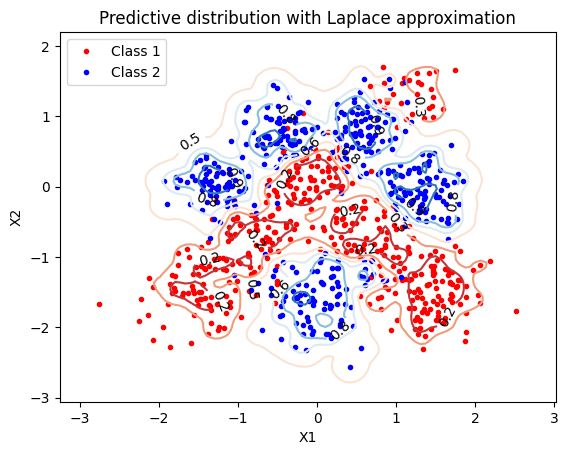

In [128]:
plot_predictive_distribution(X_train, y_train, w_map, S_N, laplace_prediction, 'Predictive distribution with Laplace approximation')

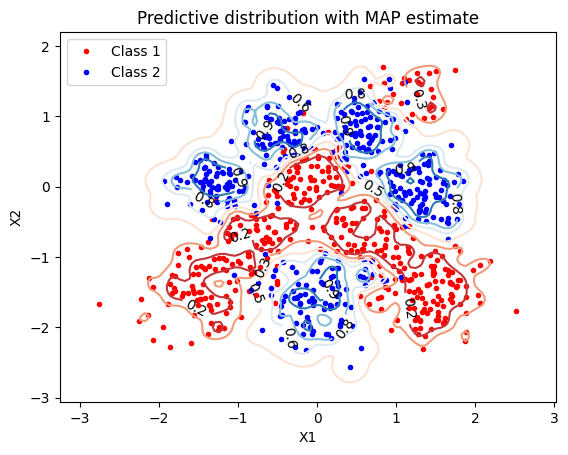

In [136]:
plot_predictive_distribution(X_train, y_train, w_map, S_N, bayesian_prediction, 'Predictive distribution with MAP estimate')

Compute average training and test log-likelihoods for both MAP solution and Laplace approximation:

In [ ]:
# Function to compute the mean log-likelihood for the MAP estimate
#
# Input:
# X_tilde: 2d array with input features (augmented)
# y: 1d array with output class labels (0 or 1)
# w: Vector of model parameters w
#
# Output: Mean log-likelihood for the MAP estimate
def mean_ll_map(X_tilde, y, w):
    k = predict(X_tilde, w)
    return np.mean(y * np.log(k) + (1 - y) * np.log(1 - k))

In [ ]:
##
# Function to compute the mean log-likelihood for the Bayesian estimate
#
# Input:
# X_tilde: 2d array with input features (augmented)
# y: 1d array with output class labels (0 or 1)
# w: Vector of model parameters w
# S_N: Covariance matrix of the posterior distribution
#
# Output: Mean log-likelihood for the Bayesian estimate

def mean_ll_bayes(X_tilde, y, w, S_N):
    pred_mean = X_tilde @ w
    pred_var = np.array([x @ S_N @ x for x in X_tilde])
    return np.mean(y * np.log(logistic(pred_mean / kappa(pred_var))) + (1 - y) * np.log(1 - logistic(pred_mean / kappa(pred_var))))

In [147]:
train_ll_map = mean_ll_map(X_tilde_train, y_train, w_map)
test_ll_map = mean_ll_map(X_tilde_test, y_test, w_map)
train_ll_map, test_ll_map

(-0.2204037653226446, -0.29286732893457956)

In [148]:
train_ll_bayes = mean_ll_bayes(X_tilde_train, y_train, w_map, S_N)
test_ll_bayes = mean_ll_bayes(X_tilde_test, y_test, w_map, S_N)
train_ll_bayes, test_ll_bayes

(-0.2600673992105267, -0.31823619477622617)

Compute confusion matrix for both MAP solution and Laplace approximation:

In [149]:
from sklearn.metrics import confusion_matrix

In [156]:
# Function to apply a threshold to likelihood values
#
# Input:
# ll: Array of likelihood values
# thres: Threshold value
#
# Output: Array of binary values (0 or 1) based on the threshold
def threshold(ll, thres):
    return np.array([1 if likelihood > thres else 0 for likelihood in ll])

In [155]:
X_tilde = get_x_tilde(evaluate_basis_functions(l, X, X_train))
thres = 0.5

ll_map_thres = threshold(bayesian_prediction(X_tilde, w_map, S_N)[0], thres)
ll_bayes_thres = threshold(laplace_prediction(X_tilde, w_map, S_N)[0], thres)

confusion_matrix(y, ll_map_thres, normalize="true"), confusion_matrix(y, ll_bayes_thres, normalize="true")

(array([[0.9486166 , 0.0513834 ],
        [0.05870445, 0.94129555]]),
 array([[0.9486166 , 0.0513834 ],
        [0.05870445, 0.94129555]]))

Tune $\sigma_0$ (variance of prior distribution) and $l$ (width of RBF basis) by optimizing estimated model evidence obtained from Laplace approximation:

In [233]:
def hp_tune(X_train, y_train, m_0, sigma_min, sigma_max, l_min, l_max, n):
    sigmas = np.linspace(sigma_min, sigma_max, n)
    ls = np.linspace(l_min, l_max, n)
    
    l_opt = 0
    sigma_opt = 0
    log_evidence_opt = -np.inf

    log_evidence_list = np.zeros((n, n))

    for i, l in enumerate(ls):
        X_tilde_train = get_x_tilde(evaluate_basis_functions(l, X_train, X_train))
        for j, sigma in enumerate(sigmas):
            S = sigma * np.eye(X_tilde_train.shape[1])
            print(f"l: {l}, sigma: {sigma}")
            _, _, log_evidence = laplace_approx(X_tilde_train, y_train, S, m_0)
            log_evidence_list[i][j] = log_evidence

            if log_evidence > log_evidence_opt:
                l_opt = i
                sigma_opt = j
                log_evidence_opt = log_evidence
            
            print(f"Evidence: {log_evidence_list[i][j]}")
            
    return ls[l_opt], sigmas[sigma_opt], log_evidence_opt, log_evidence_list, ls, sigmas


In [175]:
import seaborn as sns
def plot_grid_search(ls, sigmas, evidence_list, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(evidence_list, 
                annot=True,
                fmt='.2f',
                cmap='viridis',
                xticklabels=[float('%.3g'%sig) for sig in sigmas],
                yticklabels=[float('%.3g'%l) for l in ls],)
    
    plt.title(title)
    plt.xlabel('$\sigma_0^2$')
    plt.ylabel('$l$')

In [264]:
l_opt, sigma_opt, evidence_opt, evidence_list, ls, sigmas = hp_tune(X_train, 
                                                                    y_train,
                                                                    m_0,
                                                                    sigma_min=0.98, 
                                                                    sigma_max=1.02, 
                                                                    l_min=0.45, 
                                                                    l_max=0.55, 
                                                                    n=10)

l: 0.45, sigma: 0.98
Evidence: -197.71737343393812
l: 0.45, sigma: 0.9844444444444445
Evidence: -195.91568886045403
l: 0.45, sigma: 0.9888888888888889
Evidence: -194.12327185206854
l: 0.45, sigma: 0.9933333333333333
Evidence: -192.33810151195115
l: 0.45, sigma: 0.9977777777777778
Evidence: -190.56131420026372
l: 0.45, sigma: 1.0022222222222221
Evidence: -188.79137988164575
l: 0.45, sigma: 1.0066666666666666
Evidence: -187.03137124674655
l: 0.45, sigma: 1.011111111111111
Evidence: -185.27848179848604
l: 0.45, sigma: 1.0155555555555555
Evidence: -183.53292953576994
l: 0.45, sigma: 1.02
Evidence: -181.79541910298002
l: 0.46111111111111114, sigma: 0.98
Evidence: -197.5170589628296
l: 0.46111111111111114, sigma: 0.9844444444444445
Evidence: -195.71502654702422
l: 0.46111111111111114, sigma: 0.9888888888888889
Evidence: -193.9225286363599
l: 0.46111111111111114, sigma: 0.9933333333333333
Evidence: -192.13619104108844
l: 0.46111111111111114, sigma: 0.9977777777777778
Evidence: -190.3584077901

In [266]:
l_opt, sigma_opt, evidence_opt, evidence_list.shape

(0.5166666666666667, 1.02, -181.1231365534225, (10, 10))

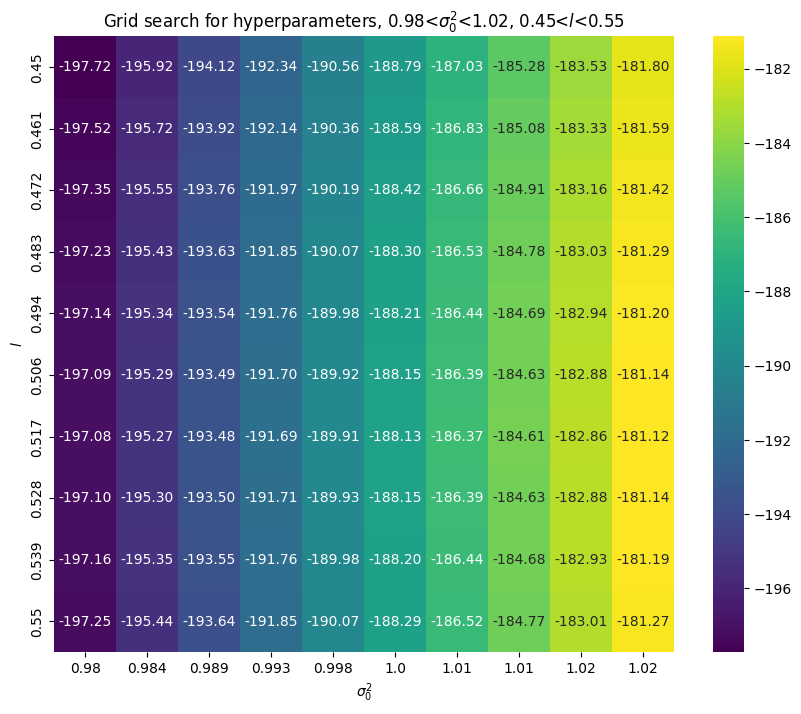

In [267]:
plot_grid_search(ls, sigmas, evidence_list, title=f'Grid search for hyperparameters, ${sigmas[0]}\less\sigma_0^2\less{sigmas[-1]}$, ${ls[0]}\less l\less{ls[-1]}$')